In [1]:
import os, sys
import shutil
import urllib.request
import zipfile
os.chdir("/home/ubuntu/MBE")

import argparse
import csv
import re

import pandas as pd
import numpy as np
from dateutil import relativedelta
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import sklearn.preprocessing as preprocessing

from src.utils.prepare_kg import parse_directed
from src.utils.prepare_kg import parse_undirected
import src.pageRank as pageRank
import operator

# Load Arguments

In [2]:
#dataset = "FB-MBE"
dataset = "ML-1M_2000_sim"

os.path.join(os.getcwd(), 'data', dataset)

'/home/ubuntu/MBE/data/ML-1M_2000_sim'

In [3]:
parser = argparse.ArgumentParser(description='MBE')

# Experiment control
parser.add_argument('--process_data', action='store_true',
                    help='process knowledge graph (default: False)')
parser.add_argument('--train', action='store_true',
                    help='run path selection set_policy training (default: False)')
parser.add_argument('--inference', action='store_true',
                    help='run knowledge graph inference (default: False)')

parser.add_argument('--dataset', type=str, default='WN-MBE',
                    help='dataset (default: WN-MBE, FB-MBE, NELL-MBE)')
parser.add_argument('--data_dir', type=str, default=os.path.join(os.getcwd(), 'data', dataset),
                    help='directory where the knowledge graph data is stored (default: None)')
parser.add_argument('--model_root_dir', type=str, default=os.path.join(os.getcwd(), 'model', dataset),
                    help='root directory where the model parameters are stored (default: None)')
parser.add_argument('--model_dir', type=str, default=os.path.join(os.getcwd(), 'model', dataset),
                    help='directory where the model parameters are stored (default: None)')
parser.add_argument('--evaluation_dir', type=str, default=os.path.join(os.getcwd(), 'model', 'evaluation'),
                    help='root directory where the model parameters are stored (default: None)')
parser.add_argument('--gpu', dest='gpu', type=int, default=0,
                    help='gpu device (default: 0)')
parser.add_argument('--checkpoint_path', type=str, default=None,
                    help='path to a pretrained checkpoint')

# Network Architecture
parser.add_argument('--model', type=str, default='point',
                    help='knowledge graph QA model (default: point)')
parser.add_argument('--emb_dim', type=int, default=100, metavar='E',
                    help='embedding dimension (default: 100)')
parser.add_argument('--history_dim', type=int, default=100, metavar='H',
                    help='action history encoding LSTM hidden states dimension (default: 400)')
parser.add_argument('--history_num_layers', type=int, default=3, metavar='L',
                    help='action history encoding LSTM number of layers (default: 1)')
parser.add_argument('--use_action_space_bucketing', type=bool, default=True,
                    help='bucket adjacency list by outgoing degree to avoid memory blow-up (default: True)')
parser.add_argument('--bucket_interval', type=int, default=10,
                    help='adjacency list bucket size (default: 32)')

# Optimization
parser.add_argument('--num_epochs', type=int, default=200,
                    help='maximum number of pass over the entire training set (default: 20)')
parser.add_argument('--num_wait_epochs', type=int, default=5,
                    help='number of epochs to wait before stopping training if dev set performance drops')
parser.add_argument('--num_peek_epochs', type=int, default=2,
                    help='number of epochs to wait for next dev set result check (default: 2)')
parser.add_argument('--start_epoch', type=int, default=0,
                    help='epoch from which the training should start (default: 0)')
parser.add_argument('--batch_size', type=int, default=256,
                    help='mini-batch size (default: 256)')
parser.add_argument('--train_batch_size', type=int, default=256,
                    help='mini-batch size during training (default: 256)')
parser.add_argument('--dev_batch_size', type=int, default=64,
                    help='mini-batch size during inferece (default: 64)')
parser.add_argument('--margin', type=float, default=0,
                    help='margin used for base MAMES training (default: 0)')
parser.add_argument('--learning_rate', type=float, default=0.001,
                    help='learning rate (default: 0.001)')
parser.add_argument('--learning_rate_decay', type=float, default=1.0,
                    help='learning rate decay factor for the Adam optimizer (default: 1)')
parser.add_argument('--adam_beta1', type=float, default=0.9,
                    help='Adam: decay rates for the first movement estimate (default: 0.9)')
parser.add_argument('--adam_beta2', type=float, default=0.999,
                    help='Adam: decay rates for the second raw movement estimate (default: 0.999)')
parser.add_argument('--grad_norm', type=float, default=10000,
                    help='norm threshold for gradient clipping (default 10000)')
parser.add_argument('--xavier_initialization', type=bool, default=True,
                    help='Initialize all model parameters using xavier initialization (default: True)')

# Graph Completion
parser.add_argument('--theta', type=float, default=0.2,
                    help='Threshold for sifting high-confidence facts (default: 0.2)')

# Reinforcement Learning
parser.add_argument('--num_rollouts', type=int, default=20,
                    help='number of rollouts (default: 20)')
parser.add_argument('--num_rollout_steps', type=int, default=3,
                    help='maximum path length (default: 3)')
parser.add_argument('--bandwidth', type=int, default=300,
                    help='maximum number of outgoing edges to explore at each step (default: 300)')
parser.add_argument('--beta', type=float, default=0.0,
                    help='entropy regularization weight (default: 0.0)')
parser.add_argument('--gamma', type=float, default=1,
                    help='moving average weight (default: 1)')

# Search Decoding
parser.add_argument('--beam_size', type=int, default=100,
                    help='size of beam used in beam search inference (default: 100)')
'''
Note that the embedding- and rule-based baselines all mask false negative facts in the dev/test set, 
so we also set the mask_test_false negatives as 'True'
And Multi-Hop, GR, RuleGuider also use the same setting
'''
parser.add_argument('--mask_test_false_negatives', type=bool, default=True,
                    help='mask false negative examples in the dev/test set during decoding (default: True. '
                         'Use the same filter settings as other baseline methods.)')
parser.add_argument('--save_beam_search_paths', action='store_true',
                    help='save the decoded path into a CSV file (default: False)')

# MBE parameters
parser.add_argument('--batch_num', type=int, default=6,
                    help='the number of new batch and original KG (default: 5+1=6)')
parser.add_argument('--now_batch', type=int, default='0',
                    help='indicate the currently used data(train: 0, valid: 1; new batch: 2-6)')

# ablation study
parser.add_argument('--argcn', type=bool, default=True,
                    help='If true, the model will use ARGCN to generate embeddings (default: True)')
parser.add_argument('--aug_link', type=bool, default=True,
                    help='If true, the model will use augmentation links (default: True)')
parser.add_argument('--attn', type=bool, default=True,
                    help='If true, the model will use feedback attention (default: True)')

# model details
# ARGCN
parser.add_argument('--rel_agg', type=str, default='sum',
                    help='The pooling function of the relational convolutional layer (the first layer) (default: sum)')
parser.add_argument('--ent_agg', type=str, default='sum',
                    help='The aggregation method of the stacked layers (default: sum)')
parser.add_argument('--neigh_dropout', type=float, default=0.3,
                    help='Dropout rate of neighboring entities (default: 0.3)')
parser.add_argument('--node_dropout', type=float, default=0.3,
                    help='Dropout rate of entity embeddings (default: 0.3)')
parser.add_argument('--gcn_layer', type=int, default=1,
                    help='GCN layer (default: 1)')
# Augmentation link
parser.add_argument('--aug_link_threshold', type=float, default=0.3,
                    help='Confidence threshold value (default: 0.3)')
parser.add_argument('--aug_link_support_threshold', type=float, default=1.0,
                    help='Support threshold value (default: 1.0). value = predict_pos / groundtruth_pos. '
                         'Note the the rollout num = 20, so the value is in [0,20].')

# Evaluation parameters
parser.add_argument('--vs100', type=bool, default=False,
                    help='If true, the model will be evaluated with a 1vs100 setting (default: False)')
parser.add_argument('--run_analysis', action='store_true',
                    help='If true, the model will be evaluated on both validation and testing sets (default: False)')

# Knowledge Graph
parser.add_argument('--add_reverse_relations', type=bool, default=True,
                    help='add reverse relations to KB (default: True)')
parser.add_argument('--add_reversed_training_edges', action='store_true',
                    help='add reversed edges to extend training set (default: False)')
parser.add_argument('--train_entire_graph', type=bool, default=False,
                    help='add all edges in the graph to extend training set (default: False)')
parser.add_argument('--emb_dropout_rate', type=float, default=0.3,
                    help='Knowledge graph embedding dropout rate (default: 0.3)')
parser.add_argument('--zero_entity_initialization', type=bool, default=False,
                    help='Initialize all entities to zero (default: False)')
parser.add_argument('--uniform_entity_initialization', type=bool, default=False,
                    help='Initialize all entities with the same random embedding (default: False)')

args, unknown = parser.parse_known_args()

# Visualization and Analysis

## Movies

In [4]:
data_dir = args.data_dir
path = data_dir + '/movies.dat'
rename_head = 'm'

# Read CSV file into DataFrame df
df = pd.read_csv(path, sep='::', names=["id", "movie", "genre"], encoding='latin-1')
df = (df.set_index(['id', 'movie'])
   .apply(lambda x: x.str.split('|').explode())
   .reset_index())
df['year'] = df.movie.str.extract(r'(?<=\()(\d*?)(?=\))',  
                                     expand = True)
df['genre'] = df['genre'].map({genre : i for i, genre in enumerate(sorted(df.genre.unique()), 1)})
#df = df.loc[:, ['id', 'year', 'genre_id']]
long_df = pd.melt(df, id_vars=['id'], value_vars=['year', 'genre'])
long_df['id'] = long_df['id'].apply(lambda id: f'{str(rename_head)}/{str(id)}')
long_df['tail'] = long_df.apply(
    lambda row: str(rename_head) + '/' + row.variable[0] + '/' +str(row.value),
    axis=1,
)


long_df = long_df.rename(columns = {'id':'head', 'tail': 'tail', 'variable':'relation'})
long_df = long_df.loc[:, ['head', 'tail', 'relation']]
long_df

/tmp/ipykernel_13761/1130711271.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(path, sep='::', names=["id", "movie", "genre"], encoding='latin-1')


,head,tail,relation
0,m/1,m/y/1995,year
1,m/1,m/y/1995,year
2,m/1,m/y/1995,year
3,m/2,m/y/1995,year
4,m/2,m/y/1995,year
...,...,...,...
12811,m/3949,m/g/8,genre
12812,m/3950,m/g/8,genre
12813,m/3951,m/g/8,genre
12814,m/3952,m/g/8,genre


In [26]:
data_dir = args.data_dir
path = data_dir + '/movies.dat'
rename_head = 'm'

# Read CSV file into DataFrame df
df = pd.read_csv(path, sep='::', names=["id", "movie", "genre"], encoding='latin-1')
df = (df.set_index(['id', 'movie'])
   .apply(lambda x: x.str.split('|').explode())
   .reset_index())
df['year'] = df.movie.str.extract(r'(?<=\()(\d*?)(?=\))',  
                                     expand = True)
df['genre'] = df['genre'].map({genre : i for i, genre in enumerate(sorted(df.genre.unique()), 1)})
long_df = pd.melt(df, id_vars=['id'], value_vars=['year', 'genre'])
long_df['head'] = long_df['id'].apply(lambda id: f'{str(rename_head)}/{str(id)}')
long_df['tail'] = long_df.apply(
    lambda row: str(rename_head) + '/' + row.variable[0] + '/' + str(row.value),
    axis=1,
)
long_df['relation'] = long_df.apply(
    lambda row: str(rename_head) + '/' + row.variable,
    axis=1,
)
long_df = long_df.loc[:, ['head', 'tail', 'relation']]
long_df

/tmp/ipykernel_13761/1644187739.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(path, sep='::', names=["id", "movie", "genre"], encoding='latin-1')


,head,tail,relation
0,m/1,m/y/1995,m/year
1,m/1,m/y/1995,m/year
2,m/1,m/y/1995,m/year
3,m/2,m/y/1995,m/year
4,m/2,m/y/1995,m/year
...,...,...,...
12811,m/3949,m/g/8,m/genre
12812,m/3950,m/g/8,m/genre
12813,m/3951,m/g/8,m/genre
12814,m/3952,m/g/8,m/genre


In [ ]:
data_dir = args.data_dir
path = data_dir + '/movies.dat'
rename_head = 'm'

# Read CSV file into DataFrame df
df = pd.read_csv(path, sep='::', names=["id", "movie", "genre"], encoding='latin-1')
df = (df.set_index(['id', 'movie'])
   .apply(lambda x: x.str.split('|').explode())
   .reset_index())
df['year'] = df.movie.str.extract(r'(?<=\()(\d*?)(?=\))',  
                                     expand = True)
df['genre'] = df['genre'].map({genre : i for i, genre in enumerate(sorted(df.genre.unique()), 1)})
#df = df.loc[:, ['id', 'year', 'genre_id']]
long_df = pd.melt(df, id_vars=['id'], value_vars=['year', 'genre'])
long_df['id'] = long_df['id'].apply(lambda id: f'{str(rename_head)}/{str(id)}')
long_df['relation'] = long_df.apply(
    lambda row: str(rename_head) + '/' + row.variable,
    axis=1,
)
long_df['tail'] = long_df.apply(
    lambda row: str(rename_head) + '/' + row.variable[0] + '/' +str(row.value),
    axis=1,
)


long_df = long_df.rename(columns = {'id':'head', 'tail': 'tail', 'variable':'relation'})
long_df = long_df.loc[:, ['head', 'tail', 'relation']]
long_df

In [14]:
{genre : i for i, genre in enumerate(sorted(df.genre.unique()), 1)}

{'Action': 1,
 'Adventure': 2,
 'Animation': 3,
 "Children's": 4,
 'Comedy': 5,
 'Crime': 6,
 'Documentary': 7,
 'Drama': 8,
 'Fantasy': 9,
 'Film-Noir': 10,
 'Horror': 11,
 'Musical': 12,
 'Mystery': 13,
 'Romance': 14,
 'Sci-Fi': 15,
 'Thriller': 16,
 'War': 17,
 'Western': 18}

In [ ]:
df.year.unique()

array(['1995', '1994', '1996', '1976', '1993', '1992', '1988', '1967',
       '1964', '1977', '1965', '1982', '1962', '1990', '1991', '1989',
       '1937', '1940', '1969', '1981', '1973', '1970', '1960', '1955',
       '1956', '1959', '1968', '1980', '1975', '1986', '1948', '1943',
       '1963', '1950', '1946', '1987', '1997', '1974', '1958', '1949',
       '1972', '1998', '1933', '1952', '1951', '1957', '1961', '1954',
       '1934', '1944', '1942', '1941', '1953', '1939', '1947', '1945',
       '1938', '1935', '1936', '1926', '1932', '1930', '1971', '1979',
       '1966', '1978', '1985', '1983', '1984', '1931', '1922', '1927',
       '1929', '1928', '1925', '1923', '1999', '1919', '2000', '1920',
       '1921'], dtype=object)

In [ ]:
df.year.unique()

array(['1995', '1994', '1996', '1976', '1993', '1992', '1988', '1967',
       '1964', '1977', '1965', '1982', '1962', '1990', '1991', '1989',
       '1937', '1940', '1969', '1981', '1973', '1970', '1960', '1955',
       '1956', '1959', '1968', '1980', '1975', '1986', '1948', '1943',
       '1963', '1950', '1946', '1987', '1997', '1974', '1958', '1949',
       '1972', '1998', '1933', '1952', '1951', '1957', '1961', '1954',
       '1934', '1944', '1942', '1941', '1953', '1939', '1947', '1945',
       '1938', '1935', '1936', '1926', '1932', '1930', '1971', '1979',
       '1966', '1978', '1985', '1983', '1984', '1931', '1922', '1927',
       '1929', '1928', '1925', '1923', '1999', '1919', '2000', '1920',
       '1921'], dtype=object)

In [29]:
df.genre_id.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18])

## Users

In [27]:
data_dir = args.data_dir
path = data_dir + '/users.dat'
rename_head = 'u'

# Read CSV file into DataFrame df
df = pd.read_csv(path, sep='::', names=['UserID','Gender','Age','Occupation','Zip-code'])

long_df = pd.melt(df, id_vars=['UserID'], value_vars=['Gender', 'Age', 'Occupation'])
long_df['variable'] = long_df['variable'].apply(lambda x: x.lower())
long_df['head'] = long_df['UserID'].apply(lambda id: f'{str(rename_head)}/{str(id)}')
long_df['relation'] = long_df.apply(
    lambda row: str(rename_head) + '/' + row.variable,
    axis=1,
)
long_df['tail'] = long_df.apply(
    lambda row: str(rename_head) + '/' + row.variable[0] + '/' +str(row.value),
    axis=1,
)
long_df = long_df.loc[:, ['head', 'tail', 'relation']]
long_df

/tmp/ipykernel_13761/3717646362.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(path, sep='::', names=['UserID','Gender','Age','Occupation','Zip-code'])


,head,tail,relation
0,u/1,u/g/F,u/gender
1,u/2,u/g/M,u/gender
2,u/3,u/g/M,u/gender
3,u/4,u/g/M,u/gender
4,u/5,u/g/M,u/gender
...,...,...,...
18115,u/6036,u/o/15,u/occupation
18116,u/6037,u/o/1,u/occupation
18117,u/6038,u/o/1,u/occupation
18118,u/6039,u/o/0,u/occupation


In [20]:
df.Gender.unique()

array(['F', 'M'], dtype=object)

In [23]:
sorted(df.Age.unique())

[1, 18, 25, 35, 45, 50, 56]

In [24]:
sorted(df.Occupation.unique())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [35]:
long_df.variable.unique()

array(['gender', 'age', 'occupation'], dtype=object)

## Ratings

In [5]:
data_dir = args.data_dir
path = data_dir + '/ratings.dat'

# Read CSV file into DataFrame df
df = pd.read_csv(path, sep='::', names=["head", "tail", "rating", "timestamp"])
df['timestamp'] = df['timestamp'].apply(lambda x: datetime.fromtimestamp(int(x)))
#df['rating'] = df['rating'].apply(lambda x: int(x))
df['users'] = df['head'].apply(lambda id: 'user_'+ str(id))
df['movie'] = df['tail'].apply(lambda id: 'movie_'+ str(id))
df = df[(df['timestamp'] >= '2000-01-01') & (df['timestamp'] < '2001-01-01')]

# Show dataframe
print(df)

/tmp/ipykernel_2696/3022156408.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(path, sep='::', names=["head", "tail", "rating", "timestamp"])


         head  tail  rating           timestamp      users       movie
0           1  1193       5 2000-12-31 23:12:40     user_1  movie_1193
1           1   661       3 2000-12-31 23:35:09     user_1   movie_661
2           1   914       3 2000-12-31 23:32:48     user_1   movie_914
3           1  3408       4 2000-12-31 23:04:35     user_1  movie_3408
5           1  1197       3 2000-12-31 23:37:48     user_1  movie_1197
...       ...   ...     ...                 ...        ...         ...
1000204  6040  1091       1 2000-04-26 04:35:41  user_6040  movie_1091
1000205  6040  1094       5 2000-04-26 01:21:27  user_6040  movie_1094
1000206  6040   562       5 2000-04-26 01:19:06  user_6040   movie_562
1000207  6040  1096       4 2000-04-26 04:20:48  user_6040  movie_1096
1000208  6040  1097       4 2000-04-26 04:19:29  user_6040  movie_1097

[904721 rows x 6 columns]


In [12]:
head = df.groupby('head')['head'].nunique().sum()
tail = df.groupby('tail')['tail'].nunique().sum()

print(f'number of unique users: {head}')
print(f'number of unique movies: {tail}')
print(f'number of unique nodes: {head + tail}')

number of unique users: 6034
number of unique movies: 3678
number of unique nodes: 9712


In [13]:
print(df['timestamp'].min())
print(df['timestamp'].max())

2000-04-26 01:05:32
2000-12-31 23:59:34


In [6]:
print('average number of ratings per user: {}'.format(df.groupby('head')['head'].transform('count').mean()))
print('minimum number of ratings by a user: {}'.format(df.groupby('head')['head'].transform('count').min()))
print('maximum number of ratings by a user: {}'.format(df.groupby('head')['head'].transform('count').max()))
print('average number of ratings per movie: {}'.format(df.groupby('tail')['tail'].transform('count').mean()))
print('minimum number of ratings for a movie: {}'.format(df.groupby('tail')['tail'].transform('count').min()))
print('maximum number of ratings for a movie: {}'.format(df.groupby('tail')['tail'].transform('count').max()))

average number of ratings per user: 389.9080442187583
minimum number of ratings by a user: 20
maximum number of ratings by a user: 2314
average number of ratings per movie: 816.2355197763667
minimum number of ratings for a movie: 1
maximum number of ratings for a movie: 3428


In [29]:
movies_few_ratings = df.groupby('tail').filter(lambda x: x['rating'].count() < 20)
#movies_few_ratings.groupby('tail')['rating'].count()
print('number of movies with fewer then 20 ratings: {}'.format(movies_few_ratings.groupby('tail')['tail'].nunique().sum()))
print('number of ratings for movies with fewer then 20 ratings: {}'.format(movies_few_ratings.groupby('tail')['rating'].count().sum()))

number of movies with fewer then 20 ratings: 663
number of ratings for movies with fewer then 20 ratings: 4717


In [38]:
print('latest date that a movie got its first rating: {}'.format(df.groupby('tail')['timestamp'].min().max()))


latest date that a movie got its first rating: 2002-11-05 00:16:03


Text(0, 0.5, 'number of recommendations')

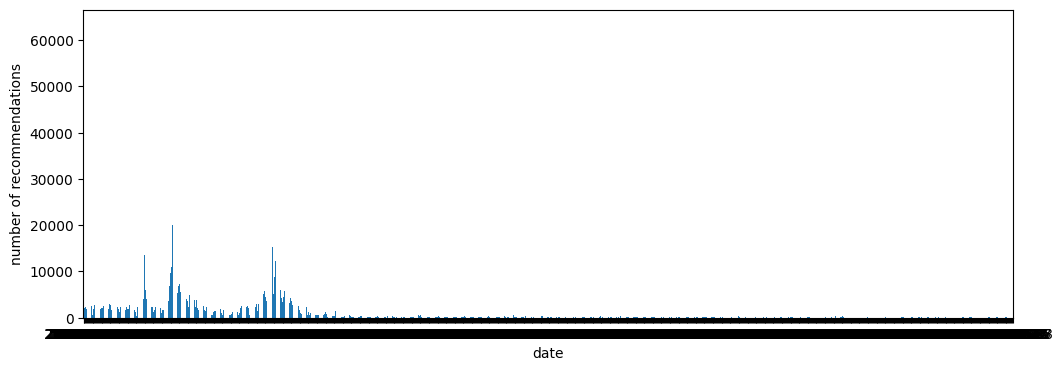

In [39]:
fig, axs = plt.subplots(figsize=(12, 4))

df.groupby(df["timestamp"].dt.date)["head"].count().plot(

    kind='bar', rot=0, ax=axs

)

plt.xlabel("date")  # custom x label using Matplotlib

plt.ylabel("number of recommendations")

Text(0, 0.5, 'number of recommendations')

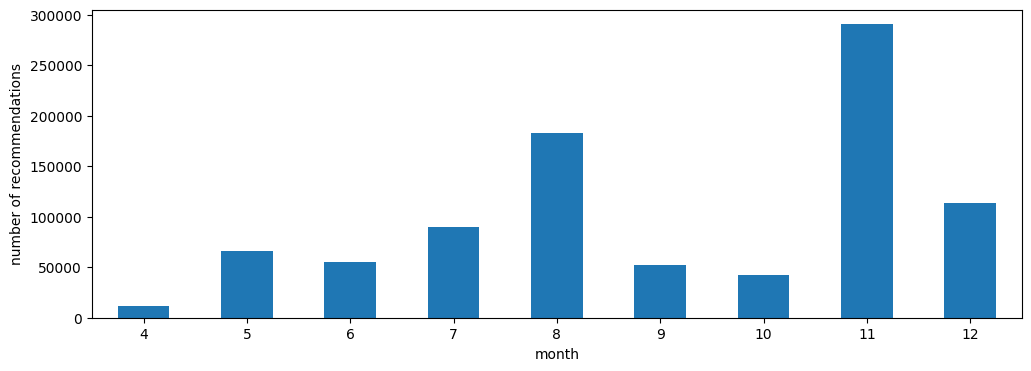

In [14]:
fig, axs = plt.subplots(figsize=(12, 4))

df.groupby(df["timestamp"].dt.month)["head"].count().plot(

    kind='bar', rot=0, ax=axs

)

plt.xlabel("month")  # custom x label using Matplotlib

plt.ylabel("number of recommendations")

Text(0, 0.5, 'number of recommendations')

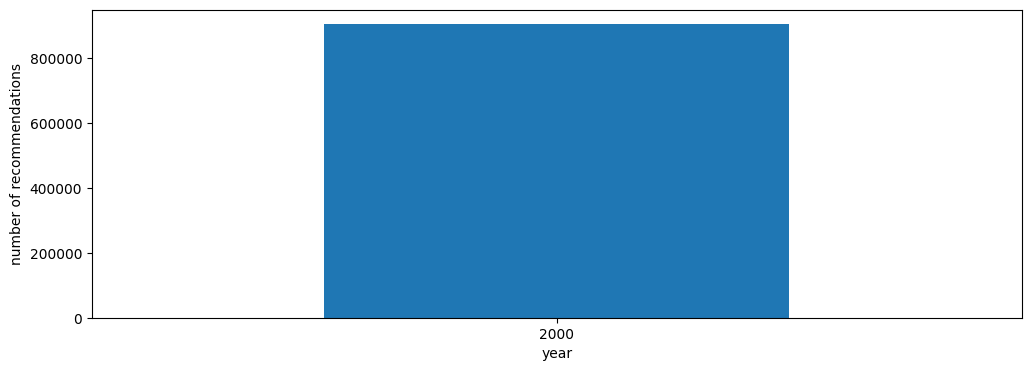

In [15]:
fig, axs = plt.subplots(figsize=(12, 4))

df.groupby(df["timestamp"].dt.year)["head"].count().plot(

    kind='bar', rot=0, ax=axs

)

plt.xlabel("year")  # custom x label using Matplotlib

plt.ylabel("number of recommendations")

Text(0, 0.5, 'number of recommendations')

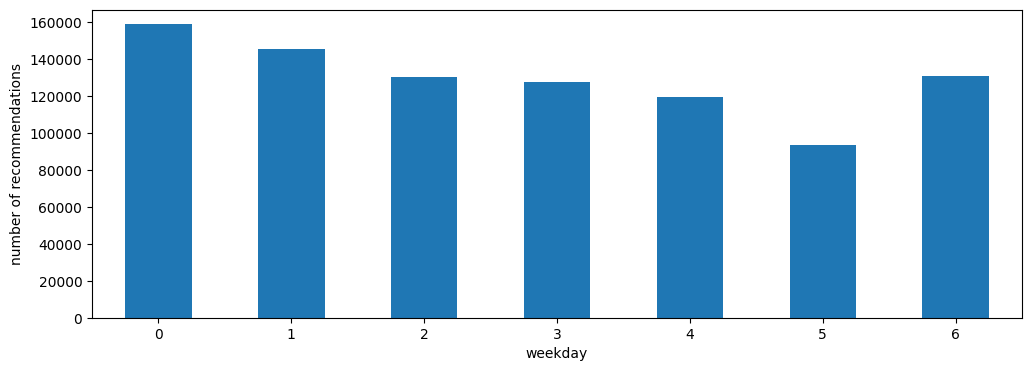

In [16]:
fig, axs = plt.subplots(figsize=(12, 4))

df.groupby(df["timestamp"].dt.weekday)["head"].count().plot(

    kind='bar', rot=0, ax=axs

)

plt.xlabel("weekday")  # custom x label using Matplotlib

plt.ylabel("number of recommendations")

Text(0, 0.5, 'number of recommendations')

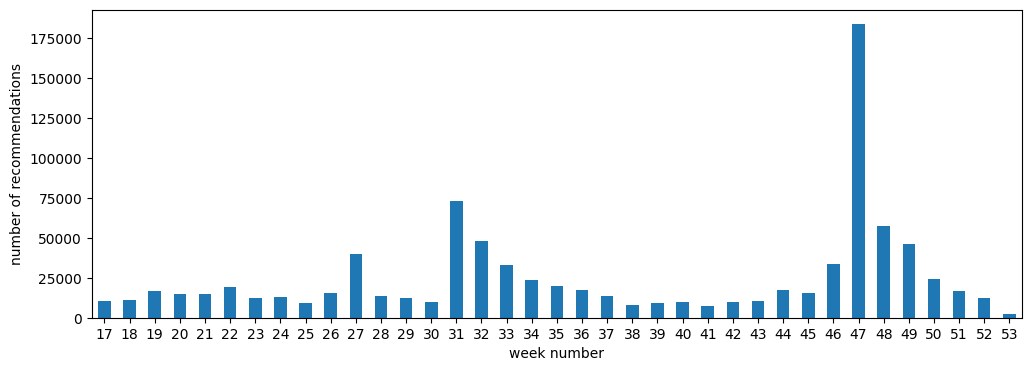

In [8]:
fig, axs = plt.subplots(figsize=(12, 4))

df.groupby(df["timestamp"].dt.strftime('%U'))["head"].count().plot(

    kind='bar', rot=0, ax=axs

)

plt.xlabel("week number")  # custom x label using Matplotlib

plt.ylabel("number of recommendations")

In [40]:
def get_week_number_from_date(date):
    return int(datetime.strptime(date, '%Y-%m-%d').strftime('%U'))

In [48]:
get_week_number_from_date('2000-09-01')

35

In [60]:
def get_first_date_from_week_number(week_number):
    return datetime.strptime('2000-W{}'.format(week_number) + '-1', "%Y-W%W-%w")

In [58]:
get_first_date_from_week_number(35+1)

2000-09-04 00:00:00


In [59]:
c = get_first_date_from_week_number(35+1)
c

2000-09-04 00:00:00


In [64]:
a = get_week_number_from_date('2000-09-01')
b = get_first_date_from_week_number(35+1)
c = get_first_date_from_week_number(47)
print(f'weeknumber of off the cutoff-date for the base-partition: {a}\n',
f'date to cut off base-partition, to only leave full weeks in additional partitions: {b}\n',
f'date to cut off dataset, because number of entries in week 47 is just too high: {c}')

weeknumber of off the cutoff-date for the base-partition: 35
 date to cut off base-partition, to only leave full weeks in additional partitions: 2000-09-04 00:00:00
 date to cut off dataset, because number of entries in week 47 is just too high: 2000-11-20 00:00:00


# Similarity score

Code from: https://github.com/pratiknabriya/Recommender-System-Collaborative-Filtering-MovieLens/blob/main/collaborative_filtering_movielense.ipynb

## User similarities

In [36]:

path = args.data_dir + '/ratings.dat'
df = pd.read_csv(path, sep='::', names=["head", "tail", "relation", "timestamp"])
df['timestamp'] = df['timestamp'].apply(lambda x: datetime.fromtimestamp(int(x)))
df_base = df[(df['timestamp'] < '2000-09-04')]

/tmp/ipykernel_49599/2862238157.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(path, sep='::', names=["head", "tail", "relation", "timestamp"])


In [37]:
# pivot ratings into movie features
user_data = df_base.pivot(index = 'head', columns = 'tail', values = 'relation').fillna(0)
user_data.head()

tail,1,2,3,4,5,6,7,8,9,10,...,3874,3875,3876,3877,3878,3879,3880,3882,3884,3886
head,,,,,,,,,,,,,,,,,,,,,
3303,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3304,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3305,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3306,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3307,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
# User Similarity Matrix using Cosine similarity as a similarity measure between Users
user_similarity = cosine_similarity(user_data)
user_similarity[np.isnan(user_similarity)] = 0
print(user_similarity)
print(user_similarity.shape)

[[1.         0.08074395 0.         ... 0.10147709 0.0901122  0.13363249]
 [0.08074395 1.         0.12726759 ... 0.05100554 0.24417149 0.29891377]
 [0.         0.12726759 1.         ... 0.0571239  0.         0.19354357]
 ...
 [0.10147709 0.05100554 0.0571239  ... 1.         0.16171426 0.08653594]
 [0.0901122  0.24417149 0.         ... 0.16171426 1.         0.21094536]
 [0.13363249 0.29891377 0.19354357 ... 0.08653594 0.21094536 1.        ]]
(2738, 2738)


In [25]:
count_1 = 0
count_2 = 0
count_3 = 0
count_4 = 0
count_5 = 0
count_6 = 0
count_7 = 0
count_8 = 0
count_9 = 0
count_10 = 0

for i in range(len(user_similarity)):
    for j in range(len(user_similarity[i])):
        if i != j:
            if user_similarity[i][j] < 0.1:
                count_1 += 1
            elif user_similarity[i][j] < 0.2:
                count_2 += 1
            elif user_similarity[i][j] < 0.3:
                count_3 += 1
            elif user_similarity[i][j] < 0.4:
                count_4 += 1
            elif user_similarity[i][j] < 0.5:
                count_5 += 1
            elif user_similarity[i][j] < 0.6:
                count_6 += 1
            elif user_similarity[i][j] < 0.7:
                count_7 += 1
            elif user_similarity[i][j] < 0.8:
                count_8 += 1
            elif user_similarity[i][j] < 0.9:
                count_8 += 1
            else:
                count_9 += 1
                
print('similarity below 0.1: {},\nsimilarity below 0.2: {},\nsimilarity below 0.3: {},\nsimilarity below 0.4: {},\nsimilarity below 0.5: {},\nsimilarity below 0.6: {},\nsimilarity below 0.7: {},\nsimilarity below 0.8: {},\nsimilarity below 0.9: {},\nsimilarity above 0.9: {}'.format(count_1, count_2, count_3, count_4, count_5, count_6, count_7, count_8, count_9, count_10))

similarity below 0.1: 3481152,
similarity below 0.2: 2567880,
similarity below 0.3: 1093798,
similarity below 0.4: 296862,
similarity below 0.5: 49108,
similarity below 0.6: 4862,
similarity below 0.7: 236,
similarity below 0.8: 8,
similarity below 0.9: 0,
similarity above 0.9: 0


In [32]:
similarity_triples = []
for i in range(len(user_similarity)):
    for j in range(len(user_similarity[i])):
        if i != j:
            if user_similarity[i][j] >= 0.7:
                similarity_triples.append([i + 1, j + 1, 'very_similar_user'])
            elif user_similarity[i][j] >= 0.5:
                similarity_triples.append([i + 1, j + 1, 'similar_user'])

In [33]:
similarity_triples

[[6, 9, 'similar_user'],
 [6, 454, 'similar_user'],
 [6, 506, 'similar_user'],
 [6, 632, 'similar_user'],
 [6, 731, 'similar_user'],
 [6, 739, 'similar_user'],
 [6, 1050, 'similar_user'],
 [6, 1084, 'similar_user'],
 [6, 1423, 'similar_user'],
 [6, 1506, 'similar_user'],
 [6, 1709, 'similar_user'],
 [9, 6, 'similar_user'],
 [9, 324, 'similar_user'],
 [9, 506, 'similar_user'],
 [9, 545, 'similar_user'],
 [9, 627, 'similar_user'],
 [9, 632, 'similar_user'],
 [9, 739, 'similar_user'],
 [9, 936, 'similar_user'],
 [9, 1010, 'similar_user'],
 [9, 1050, 'similar_user'],
 [9, 1084, 'similar_user'],
 [9, 1144, 'similar_user'],
 [9, 1423, 'similar_user'],
 [9, 1506, 'similar_user'],
 [9, 2266, 'similar_user'],
 [9, 2486, 'similar_user'],
 [15, 154, 'similar_user'],
 [50, 226, 'similar_user'],
 [52, 526, 'similar_user'],
 [52, 807, 'similar_user'],
 [52, 874, 'similar_user'],
 [52, 937, 'similar_user'],
 [52, 1366, 'similar_user'],
 [52, 1642, 'similar_user'],
 [52, 1786, 'similar_user'],
 [52, 2

In [34]:
len(similarity_triples)

5106

## Movie similarities

In [36]:
# pivot ratings into movie features
movie_data = df_base.pivot(index = 'tail', columns = 'head', values = 'relation').fillna(0)
movie_data.head()

head,3303,3304,3305,3306,3307,3308,3309,3310,3311,3312,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
tail,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,5.0,0.0,5.0,4.0,0.0,3.0,4.0,...,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0
2,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [37]:
# User Similarity Matrix using Cosine similarity as a similarity measure between Users
movie_similarity = cosine_similarity(movie_data)
movie_similarity[np.isnan(movie_similarity)] = 0
print(movie_similarity)
print(movie_similarity.shape)

[[1.         0.38621799 0.25326755 ... 0.03139306 0.03688611 0.024289  ]
 [0.38621799 1.         0.2365791  ... 0.02208092 0.         0.02633805]
 [0.25326755 0.2365791  1.         ... 0.         0.07737374 0.        ]
 ...
 [0.03139306 0.02208092 0.         ... 1.         0.         0.        ]
 [0.03688611 0.         0.07737374 ... 0.         1.         0.        ]
 [0.024289   0.02633805 0.         ... 0.         0.         1.        ]]
(3462, 3462)


In [38]:
count_1 = 0
count_2 = 0
count_3 = 0
count_4 = 0
count_5 = 0
count_6 = 0
count_7 = 0
count_8 = 0
count_9 = 0
count_10 = 0

for i in range(len(movie_similarity)):
    for j in range(len(movie_similarity[i])):
        if i != j:
            if movie_similarity[i][j] < 0.1:
                count_1 += 1
            elif movie_similarity[i][j] < 0.2:
                count_2 += 1
            elif movie_similarity[i][j] < 0.3:
                count_3 += 1
            elif movie_similarity[i][j] < 0.4:
                count_4 += 1
            elif movie_similarity[i][j] < 0.5:
                count_5 += 1
            elif movie_similarity[i][j] < 0.6:
                count_6 += 1
            elif movie_similarity[i][j] < 0.7:
                count_7 += 1
            elif movie_similarity[i][j] < 0.8:
                count_8 += 1
            elif movie_similarity[i][j] < 0.9:
                count_8 += 1
            else:
                count_9 += 1
                
print('similarity below 0.1: {},\nsimilarity below 0.2: {},\nsimilarity below 0.3: {},\nsimilarity below 0.4: {},\nsimilarity below 0.5: {},\nsimilarity below 0.6: {},\nsimilarity below 0.7: {},\nsimilarity below 0.8: {},\nsimilarity below 0.9: {},\nsimilarity above 0.9: {}'.format(count_1, count_2, count_3, count_4, count_5, count_6, count_7, count_8, count_9, count_10))

similarity below 0.1: 8764314,
similarity below 0.2: 2410748,
similarity below 0.3: 627382,
similarity below 0.4: 144562,
similarity below 0.5: 29132,
similarity below 0.6: 4752,
similarity below 0.7: 736,
similarity below 0.8: 214,
similarity below 0.9: 142,
similarity above 0.9: 0


In [39]:
similarity_triples = []
for i in range(len(movie_similarity)):
    for j in range(len(movie_similarity[i])):
        if i != j:
            if movie_similarity[i][j] >= 0.7:
                similarity_triples.append([i + 1, j + 1, 'very_similar_movie'])
            elif movie_similarity[i][j] >= 0.5:
                similarity_triples.append([i + 1, j + 1, 'similar_movie'])

In [40]:
similarity_triples

[[1, 34, 'similar_movie'],
 [1, 247, 'similar_movie'],
 [1, 281, 'similar_movie'],
 [1, 303, 'similar_movie'],
 [1, 340, 'similar_movie'],
 [1, 348, 'similar_movie'],
 [1, 456, 'similar_movie'],
 [1, 559, 'similar_movie'],
 [1, 560, 'similar_movie'],
 [1, 966, 'similar_movie'],
 [1, 1043, 'similar_movie'],
 [1, 1044, 'similar_movie'],
 [1, 1045, 'similar_movie'],
 [1, 1057, 'similar_movie'],
 [1, 1110, 'similar_movie'],
 [1, 1115, 'similar_movie'],
 [1, 1228, 'similar_movie'],
 [1, 1372, 'similar_movie'],
 [1, 1753, 'similar_movie'],
 [1, 2053, 'similar_movie'],
 [1, 2094, 'similar_movie'],
 [1, 2259, 'similar_movie'],
 [1, 2390, 'similar_movie'],
 [1, 2467, 'similar_movie'],
 [1, 2584, 'similar_movie'],
 [1, 2772, 'similar_movie'],
 [2, 3098, 'similar_movie'],
 [6, 47, 'similar_movie'],
 [6, 433, 'similar_movie'],
 [6, 450, 'similar_movie'],
 [6, 958, 'similar_movie'],
 [6, 1979, 'similar_movie'],
 [10, 155, 'similar_movie'],
 [10, 333, 'similar_movie'],
 [10, 361, 'similar_movie'],
 

In [44]:
df_similarity = pd.DataFrame(similarity_triples, columns=["head", "tail", "relation"])
df_similarity

,head,tail,relation
0,1,34,similar_movie
1,1,247,similar_movie
2,1,281,similar_movie
3,1,303,similar_movie
4,1,340,similar_movie
...,...,...,...
5839,3457,1935,similar_movie
5840,3457,2794,similar_movie
5841,3457,3237,similar_movie
5842,3457,3366,similar_movie


In [41]:
len(similarity_triples)

5844

## Similarity without rating bias

In [ ]:
def similaritiy_nobias(df_base, kind='user'):
    if kind == 'user':
        df_ratings = df_base.pivot(index = 'head', columns = 'tail', values = 'relation')
        ratings = df_ratings.to_numpy()
        user_bias = np.nanmean(ratings, axis=1) - np.nanmean(ratings)
        ratings = (ratings - user_bias[:, np.newaxis]).copy()
        ratings[np.isnan(ratings)] = 0
        similarity = cosine_similarity(ratings)
    elif kind == 'item':
        df_ratings = df_base.pivot(index = 'tail', columns = 'head', values = 'relation')
        ratings = df_ratings.to_numpy()
        item_bias = np.nanmean(ratings, axis=1) - np.nanmean(ratings)
        ratings = (ratings - item_bias[:, np.newaxis]).copy()
        ratings[np.isnan(ratings)] = 0
        similarity = cosine_similarity(ratings)
        
    return similarity

In [ ]:
user_similarity = similaritiy_nobias(df_base, kind='user')

array([[1.        , 0.08094678, 0.        , ..., 0.10331961, 0.08945853,
        0.13428688],
       [0.08094678, 1.        , 0.12737429, ..., 0.04889715, 0.24081624,
        0.2993792 ],
       [0.        , 0.12737429, 1.        , ..., 0.05842621, 0.        ,
        0.19534791],
       ...,
       [0.10331961, 0.04889715, 0.05842621, ..., 1.        , 0.16263696,
        0.0865185 ],
       [0.08945853, 0.24081624, 0.        , ..., 0.16263696, 1.        ,
        0.21098828],
       [0.13428688, 0.2993792 , 0.19534791, ..., 0.0865185 , 0.21098828,
        1.        ]])

In [103]:
user_similarity.shape

(2738, 2738)

In [104]:
movie_similarity = similaritiy_nobias(df_base, kind='item')
movie_similarity

array([[1.        , 0.38731819, 0.25619592, ..., 0.03062744, 0.03449319,
        0.02448689],
       [0.38731819, 1.        , 0.2411572 , ..., 0.0219973 , 0.        ,
        0.02882269],
       [0.25619592, 0.2411572 , 1.        , ..., 0.        , 0.07224755,
        0.        ],
       ...,
       [0.03062744, 0.0219973 , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.03449319, 0.        , 0.07224755, ..., 0.        , 1.        ,
        0.        ],
       [0.02448689, 0.02882269, 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [105]:
movie_similarity.shape

(3462, 3462)

# Creat Dataset Partitions and Page Rank Scores

In [5]:
def load_rating_data(path, rename_head, rename_tail):
    path += '/ratings.dat'

    # Read CSV file into DataFrame df
    df = pd.read_csv(path, sep='::', names=["head", "tail", "relation", "timestamp"])
    df['timestamp'] = df['timestamp'].apply(lambda x: datetime.fromtimestamp(int(x)))
    
    df['head'] = df['head'].apply(lambda id: f'{rename_head}/{id}')
    df['tail'] = df['tail'].apply(lambda id: f'{rename_tail}/{id}')
    #df['relation'] = df['relation'].apply(lambda id: f'{rename_relation}/{id}')
    
    return df

In [6]:
def load_rating_data_with_categorization(path, rename_head='', rename_tail='', adjust_rating_bias=False):
    path += '/ratings.dat'

    # Read CSV file into DataFrame df
    df = pd.read_csv(path, sep='::', names=["head", "tail", "relation", "timestamp"])
    df['timestamp'] = df['timestamp'].apply(lambda x: datetime.fromtimestamp(int(x)))
    if len(rename_head) > 0:
        df['head'] = df['head'].apply(lambda id: f'{rename_head}/{id}')
    if len(rename_tail) > 0:
        df['tail'] = df['tail'].apply(lambda id: f'{rename_tail}/{id}')

    # adjust for rating bias of the user by ajusting each rating by subtracting the global mean from the mean rating of the respective user
    if adjust_rating_bias:
        similarity_matrix = df.pivot(index = 'head', columns = 'tail', values = 'relation')
        id_list = list(similarity_matrix.index.values)
        
        movie_id_list = df.pivot(index = 'tail', columns = 'head', values = 'relation').index.values
        ratings = similarity_matrix.to_numpy()
        user_bias = np.nanmean(ratings, axis=1) - np.nanmean(ratings)
        ratings = (ratings - user_bias[:, np.newaxis]).copy()
        df_sim = pd.DataFrame(ratings, columns=movie_id_list, index=id_list)
        df_sim = df_sim.unstack().reset_index(name='value')
        merged = pd.merge(df, df_sim, how='left', left_on=['head', 'tail'], right_on=['level_1', 'level_0'])
        df = merged.loc[:, ['head', 'tail', 'value', 'timestamp']]
        df.rename(columns={'value': 'relation'}, inplace=True)
    
        cutoff_rating = df['relation'].mean()
    else:
        cutoff_rating = 4
    
    df["relation_new"] = df['relation'].apply(lambda x: str(rename_head) + '/' + 'likes' if x >= cutoff_rating else str(rename_head)  + '/' +  'dislikes')
    
    return df

In [7]:
def load_movie_data(path, rename_head):
   path += '/movies.dat'

   # Read CSV file into DataFrame df
   df = pd.read_csv(path, sep='::', names=["id", "movie", "genre"], encoding='latin-1')
   df = (df.set_index(['id', 'movie'])
      .apply(lambda x: x.str.split('|').explode())
      .reset_index())
   df['year'] = df.movie.str.extract(r'(?<=\()(\d*?)(?=\))',  
                                       expand = True)
   df['genre'] = df['genre'].map({genre : i for i, genre in enumerate(sorted(df.genre.unique()), 1)})
   long_df = pd.melt(df, id_vars=['id'], value_vars=['year', 'genre'])
   long_df['head'] = long_df['id'].apply(lambda id: f'{str(rename_head)}/{str(id)}')
   long_df['tail'] = long_df.apply(
      lambda row: str(rename_head) + '/' + row.variable[0] + '/' + str(row.value),
      axis=1,
   )
   long_df['relation'] = long_df.apply(
      lambda row: str(rename_head) + '/' + row.variable,
      axis=1,
   )
   long_df = long_df.loc[:, ['head', 'tail', 'relation']]
      
   return long_df

In [8]:
def load_user_data(path, rename_head):
    path += '/users.dat'
    rename_head = 'u'

    # Read CSV file into DataFrame df
    df = pd.read_csv(path, sep='::', names=['UserID','Gender','Age','Occupation','Zip-code'])

    long_df = pd.melt(df, id_vars=['UserID'], value_vars=['Gender', 'Age', 'Occupation'])
    long_df['variable'] = long_df['variable'].apply(lambda x: x.lower())
    long_df['head'] = long_df['UserID'].apply(lambda id: f'{str(rename_head)}/{str(id)}')
    long_df['relation'] = long_df.apply(
        lambda row: str(rename_head) + '/' + row.variable,
        axis=1,
    )
    long_df['tail'] = long_df.apply(
        lambda row: str(rename_head) + '/' + row.variable[0] + '/' +str(row.value),
        axis=1,
    )
    long_df = long_df.loc[:, ['head', 'tail', 'relation']]

    return long_df

In [9]:
def calculate_similarity_old(df, rename_node='', user=True):
    if user:
        similarity_matrix = df.pivot(index = 'head', columns = 'tail', values = 'relation').fillna(0)
        #unique_df = df.drop_duplicates(subset='head')
        #id_list = unique_df['head'].tolist()
        relation = 'user'
    else:
        similarity_matrix = df.pivot(index = 'tail', columns = 'head', values ='relation').fillna(0)
        #unique_df = df.drop_duplicates(subset='tail')
        #id_list = unique_df['tail'].tolist()
        relation = 'movie'

    id_list = list(similarity_matrix.index.values)
    print(f'id_list: {len(id_list)}')
    similarity = cosine_similarity(similarity_matrix)
    similarity[np.isnan(similarity)] = 0
    print(similarity)

    similarity_triples = []
    list_i = []
    list_j = []
    very_similar = 0
    similar = 0
    # Iterate through each row of the similarity matrix
    for i, row in enumerate(similarity):
            for j, score in enumerate(row):
                if i != j and sum(row) >= 5: # only user with at least 5 ratings are considered to calculate similarity
                    if i not in list_j and j not in list_j:
                        if score >= 0.7:
                                similarity_triples.append([id_list[i], id_list[j], f'very_similar_{relation}'])
                                very_similar += 1
                        elif score >= 0.5:
                                similarity_triples.append([id_list[i], id_list[j], f'similar_{relation}'])
                                similar += 1
                    list_i.append(i), list_j.append(j)

    df_similarity = pd.DataFrame(similarity_triples, columns=["head", "tail", "relation"])
    print(f'df_similarity: {len(df_similarity)}')
    print(f'very_similar: {very_similar}, similar: {similar}, total: {similar + very_similar}')
    
    return df_similarity

In [10]:
def similaritiy_nobias(similarity_matrix, kind='u'):
    if kind == 'u':
        ratings = similarity_matrix.to_numpy()
        user_bias = np.nanmean(ratings, axis=1) - np.nanmean(ratings)
        ratings = (ratings - user_bias[:, np.newaxis]).copy()
        ratings[np.isnan(ratings)] = 0
        similarity = cosine_similarity(ratings)
    elif kind == 'm':
        ratings = similarity_matrix.to_numpy()
        item_bias = np.nanmean(ratings, axis=1) - np.nanmean(ratings)
        ratings = (ratings - item_bias[:, np.newaxis]).copy()
        ratings[np.isnan(ratings)] = 0
        similarity = cosine_similarity(ratings)
        
    return similarity

In [11]:
def calculate_similarity(df, rename_node='', user=True):
    if user:
        similarity_matrix = df.pivot(index = 'head', columns = 'tail', values = 'relation')
        relation = 'u'
        score_to_category = [0.8, 0.9]
    else:
        similarity_matrix = df.pivot(index = 'tail', columns = 'head', values ='relation')
        relation = 'm'
        score_to_category = [0.6, 0.8]

    #print(f'shape similarity matrix before filtering: {similarity_matrix.shape}')
    similarity_matrix.dropna(axis=0, thresh=10, inplace=True)
    #print(f'shape similarity matrix after filtering: {similarity_matrix.shape}')
    id_list = list(similarity_matrix.index.values)
    similarity = similaritiy_nobias(similarity_matrix, kind=relation)


    df_sim = pd.DataFrame(similarity, columns=id_list, index=id_list)
    df_sim = df_sim.unstack().reset_index(name='value')
    print(f'shape df_sim before filtering: {df_sim.shape}')
    df_sim = df_sim[(df_sim['value'] >= score_to_category[0]) & (df_sim['level_0'] != df_sim['level_1'])]
    print(f'shape df_sim after filtering: {df_sim.shape}')
    df_sim['relation'] = df_sim['value'].apply(lambda x: f'{relation}/very_similar' if x >= score_to_category[1] else f'{relation}/similar')
    df_sim.rename(columns={'level_0': 'tail', 'level_1': 'head'}, inplace=True)
    df_sim = df_sim.loc[:, ['head', 'tail', 'relation']]
    
    return df_sim

In [12]:
def define_partitions(base_partition, partition_intervall, last_partition):
    date_for_delta = datetime.strptime(base_partition[1], "%Y-%m-%d") + relativedelta.relativedelta(day=+1)
    if partition_intervall == 'year':
        no_add = relativedelta.relativedelta(datetime.strptime(last_partition, "%Y-%m-%d"), date_for_delta).years
    elif partition_intervall =='month':
        delta = relativedelta.relativedelta(datetime.strptime(last_partition, "%Y-%m-%d"), date_for_delta)
        no_add = delta.years * 12 + delta.months
    elif partition_intervall =='week':
        delta = relativedelta.relativedelta(datetime.strptime(last_partition, "%Y-%m-%d"), date_for_delta)
        no_add = delta.years * 12 + delta.months * 4 + delta.weeks

    else:
        raise Exception(f"time-intervall {partition_intervall} not implemented or doesn't exist.")
    return no_add

In [13]:
def get_time_filter(partition_intervall, base_partition, i):
    if partition_intervall == 'year':
        date = datetime.strptime(base_partition, "%Y-%m-%d") + relativedelta.relativedelta(year=+i)
    elif partition_intervall =='month':
        date = datetime.strptime(base_partition, "%Y-%m-%d") + relativedelta.relativedelta(month=+i)
    elif partition_intervall =='week':
        date = datetime.strptime(base_partition, "%Y-%m-%d") + relativedelta.relativedelta(weeks=+i)
    else:
        raise Exception(f"time-intervall {partition_intervall} not implemented or doesn't exist.")
    
    return date.strftime("%Y-%m-%d")

In [15]:
base_partition=['1970-01-01', '2000-09-04']
partition_intervall='week'
last_partition='2000-11-19'
no_add = define_partitions(base_partition, partition_intervall, last_partition)
print(f'no_add: {no_add}')
    
for i in range(no_add):
    time_filter = get_time_filter(partition_intervall, base_partition[1], i)
    print(f'time_filter: {time_filter}')

no_add: 10
time_filter: 2000-09-04
time_filter: 2000-09-11
time_filter: 2000-09-18
time_filter: 2000-09-25
time_filter: 2000-10-02
time_filter: 2000-10-09
time_filter: 2000-10-16
time_filter: 2000-10-23
time_filter: 2000-10-30
time_filter: 2000-11-06


In [14]:
def filter_and_save_data(data_dir, df_rating, df_user, df_movie, base_partition, partition_intervall, i, rename_relation='', categorize=False, similarity=False, isDirected=True, time_filter_prev=None, temp_prev=None, temp_pgrk=None):
    if i == 0:
        time_filter = base_partition[1]
    else:
        time_filter = get_time_filter(partition_intervall, base_partition[1], i)
    df_base = df_rating[(df_rating['timestamp'] >= base_partition[0]) & (df_rating['timestamp'] < time_filter)]
    
    if similarity:
        df_user_similarity = calculate_similarity(df_base.loc[:, ['head', 'tail', 'relation']], rename_node='u', user=True)
        df_movie_similarity = calculate_similarity(df_base.loc[:, ['head', 'tail', 'relation']], rename_node='m', user=False)
        if categorize:
            df_base = df_base.loc[:, ['head', 'tail', 'relation_new', 'timestamp']]
            df_base.rename(columns = {'relation_new':'relation'}, inplace = True)
        elif rename_relation != '':
            df_base['relation'] = df_base['relation'].apply(lambda id: f'{rename_relation}/{id}')
    elif categorize:
        df_base = df_base.loc[:, ['head', 'tail', 'relation_new', 'timestamp']]
        df_base.rename(columns = {'relation_new':'relation'}, inplace = True)
    elif rename_relation != '':
        df_base['relation'] = df_base['relation'].apply(lambda id: f'{rename_relation}/{id}')
    
    if i == 0:
        paths = [f'{data_dir}', f'{data_dir}/add_{i + 1}']
        names = ['base_train.triples', 'valid.triples']
        temp_user = df_user[df_user['head'].isin(df_base['head'])]
        temp_movies = df_movie[df_movie['head'].isin(df_base['tail'])]
        #print(f'len temp_user: {len(temp_user)}, len temp_movies: {len(temp_movies)}')
        if similarity:
            temp_user_sim = df_user_similarity[(df_user_similarity['head'].isin(df_base['head']) &
                                            df_user_similarity['tail'].isin(df_base['head']))]
            temp_movies_sim = df_movie_similarity[(df_movie_similarity['head'].isin(df_base['tail']) &
                                                df_movie_similarity['tail'].isin(df_base['tail']))]
            #print(f'len temp_user_sim: {len(temp_user_sim)}, len temp_user_sim: {len(temp_movies_sim)}')
            df_base = df_base.loc[:, ['head', 'tail', 'relation']]
            temp_concat = pd.concat([temp_user, temp_movies, temp_user_sim, temp_movies_sim, df_base])
        else:
            df_base = df_base.loc[:, ['head', 'tail', 'relation']]
            temp_concat = pd.concat([temp_user, temp_movies, df_base])
        # divide based into train and validation set
        temp, temp_prev = train_test_split(temp_concat, test_size=0.2, random_state=4)
        
    else:
        paths = [f'{data_dir}/add_{i + 1}', f'{data_dir}/add_{i + 1}']
        names = ['test.triples', 'support.triples']
        temp = df_base[(df_base['timestamp'] >= time_filter_prev)]
        # filter out all occurences of temp in base, to use it for filtering user and movie data. otherwise user and movie data is added, that is already present in previous iteration
        df_base = df_base[df_base['timestamp'] < time_filter_prev]

        temp_user = df_user[df_user['head'].isin(temp['head']) &
                            ~df_user['head'].isin(df_base['head'])]
        temp_movies = df_movie[df_movie['head'].isin(temp['tail']) &
                               ~df_movie['head'].isin(df_base['tail'])]

        temp = temp.loc[:, ['head', 'tail', 'relation']]
        
    for path in paths:
        if not os.path.isdir(path): 
            os.makedirs(path)
    
    temp.to_csv(f'{paths[0]}/{names[0]}', sep='\t', index=False, header=False)
        
    if i == 0:
        if os.path.exists(f'{paths[0]}/node.pgrk'):
            os.remove(f'{paths[0]}/node.pgrk')
        generate_rank_scores(temp, f'{paths[0]}/node.pgrk', isDirected)
        temp_pgrk = pd.concat([temp_prev, temp])
            
    temp_prev.to_csv(f'{paths[1]}/{names[1]}', sep='\t', index=False, header=False)
    
    if i > 0:
        if similarity:
            temp_user_sim = df_user_similarity[df_user_similarity['head'].isin(temp['head']) &
                                            df_user_similarity['tail'].isin(temp['head']) &
                                            (~df_user_similarity['head'].isin(df_base['head']) &
                                            ~df_user_similarity['tail'].isin(df_base['head']))]
            temp_movies_sim = df_movie_similarity[df_movie_similarity['head'].isin(temp['tail']) &
                                                df_movie_similarity['tail'].isin(temp['tail']) &
                                                (~df_movie_similarity['tail'].isin(df_base['tail']) &
                                                ~df_movie_similarity['head'].isin(df_base['tail']))] 
            temp_prev = pd.concat([temp, temp_prev, temp_user, temp_movies, temp_user_sim, temp_movies_sim])
            temp_pgrk = pd.concat([temp_pgrk, temp, temp_user, temp_movies, temp_user_sim, temp_movies_sim])             
        else:
            temp_prev = pd.concat([temp, temp_prev, temp_user, temp_movies])
            temp_pgrk = pd.concat([temp_pgrk, temp, temp_user, temp_movies])
    if os.path.exists(f'{paths[1]}/node.pgrk'):
            os.remove(f'{paths[1]}/node.pgrk')
    generate_rank_scores(temp_pgrk, f'{paths[1]}/node.pgrk', isDirected)
    
    return temp_prev, temp_pgrk, time_filter

In [15]:
def filter_top_k_movies(df_rating, top_k):
    df_top_k = df_rating.groupby(['tail'])['tail'].count().nlargest(n=top_k)
    df_filtered = df_rating[df_rating['tail'].isin(df_top_k.index)]
    return df_filtered

In [16]:
def create_dataset_partition(data_dir, top_k=None, base_partition=['',''], partition_intervall='year',  last_partition='', isDirected=False, categorize=False, similarity=False):
    if categorize:
        df_rating = load_rating_data_with_categorization(data_dir, rename_head='u', rename_tail='m')
        rename_relation = ''
    else:
        df_rating = load_rating_data(data_dir, rename_head='u', rename_tail='m')
        rename_relation = 'r'
    
    if top_k:
        df_rating = filter_top_k_movies(df_rating, top_k=top_k)
        
    df_user = load_user_data(data_dir, rename_head='u')
    df_movie = load_movie_data(data_dir, rename_head='m')
    
    # calculate number of emerging patches based partition intervall and maximum date
    if last_partition == '':
        last_partition = df_rating['timestamp'].max()
    no_add = define_partitions(base_partition, partition_intervall, last_partition)
    
    for i in range(no_add + 1):
        print(f'working on current partition: {i + 1}')
        if i == 0:
            temp, temp_pgrk, time_filter_prev = filter_and_save_data(data_dir, df_rating, df_user, df_movie, base_partition, partition_intervall, i, rename_relation, categorize, similarity, isDirected)
        else:
            temp, temp_pgrk, time_filter_prev = filter_and_save_data(data_dir, df_rating, df_user, df_movie, base_partition, partition_intervall, i, rename_relation, categorize, similarity, isDirected, time_filter_prev, temp, temp_pgrk)


In [17]:
def is_float(value):
    return bool(re.match(r'^-?\d+(\.\d+)?$', value))

In [18]:
def generate_rank_scores(df, path, isDirected):

    data = df.values.tolist()

    #graph = parse_directed(data)
    graph = parse_undirected(data)

    p = pageRank.PageRank(graph, isDirected)
    p.rank()

    sorted_r = sorted(p.ranks.items(), key=operator.itemgetter(1), reverse=True)

    with open(path, mode="w") as file:
        for tup in sorted_r:
            node = str(tup[0])
            #if isinstance(node, float) or is_float(node):
            if is_float(node):
                node = round(float(node))
            
            #file.write('{0:30} :{1:10}\n'.format(str(tup[0]), tup[1]))
            file.write(f'{node:<30} :{tup[1]:10}\n')

In [65]:
a = get_week_number_from_date('2000-09-01')
b = get_first_date_from_week_number(35+1)
c = get_first_date_from_week_number(47)
print(f'weeknumber of off the cutoff-date for the base-partition: {a}\n',
f'date to cut off base-partition, to only leave full weeks in additional partitions: {b}\n',
f'date to cut off dataset, because number of entries in week 47 is just too high: {c}')

weeknumber of off the cutoff-date for the base-partition: 35
 date to cut off base-partition, to only leave full weeks in additional partitions: 2000-09-04 00:00:00
 date to cut off dataset, because number of entries in week 47 is just too high: 2000-11-20 00:00:00


In [34]:
dataset = "ML-1M_2000_full_top_100_no_bias2"

create_dataset_partition(os.path.join(os.getcwd(), 'data', dataset),
                         top_k = 100,
                         base_partition=['1970-01-01', '2000-09-04'],
                         partition_intervall='week',
                         last_partition='2000-11-19',
                         isDirected=False,
                         categorize=True,
                         similarity=True
                         )

/tmp/ipykernel_41636/396721287.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(path, sep='::', names=["head", "tail", "relation", "timestamp"])
/tmp/ipykernel_41636/2991564361.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(path, sep='::', names=['UserID','Gender','Age','Occupation','Zip-code'])
/tmp/ipykernel_41636/2413939207.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='pyt

working on current partition: 1
shape df_sim before filtering: (4866436, 3)
shape df_sim after filtering: (11732, 3)
shape df_sim before filtering: (10000, 3)
shape df_sim after filtering: (296, 3)
working on current partition: 2
shape df_sim before filtering: (5212089, 3)
shape df_sim after filtering: (13140, 3)
shape df_sim before filtering: (10000, 3)
shape df_sim after filtering: (306, 3)
working on current partition: 3
shape df_sim before filtering: (5484964, 3)
shape df_sim after filtering: (14074, 3)
shape df_sim before filtering: (10000, 3)
shape df_sim after filtering: (302, 3)
working on current partition: 4
shape df_sim before filtering: (5707321, 3)
shape df_sim after filtering: (14826, 3)
shape df_sim before filtering: (10000, 3)
shape df_sim after filtering: (310, 3)
working on current partition: 5
shape df_sim before filtering: (5929225, 3)
shape df_sim after filtering: (15626, 3)
shape df_sim before filtering: (10000, 3)
shape df_sim after filtering: (318, 3)
working on